In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

Using TensorFlow backend.


In [2]:
#read the human-labeled csv, CHANGE to your own directory
df = pd.read_csv('/Users/e5pianos/Desktop/2020 SPRING/COMP4641/project/lt_hydrator/training_licensedTreatment_combined_csv.csv',dtype=str,encoding='unicode_escape')

df = df[pd.notnull(df['label'])]
df = df[pd.notnull(df['text'])]

#input of the model will be text + quoted_text
df['full_text']=df['text'].fillna('') + ' ' + df['quoted_text'].fillna('')

<Figure size 720x288 with 0 Axes>

2    230
0    163
3    149
1    139
Name: label, dtype: int64


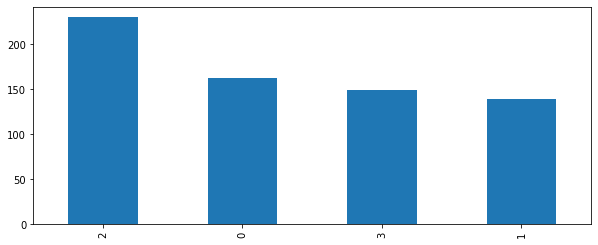

In [3]:
#statstic of classes, each class need to have at least 150 labels
my_tags = ['0','1','2','3']
plt.figure(figsize=(10,4))
df.label.value_counts().plot(kind='bar');
print(df.label.value_counts())

In [4]:
#remove redundant words
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

df['full_text'] = df['full_text'].apply(clean_text)

In [5]:
df['full_text'].apply(lambda x: len(x.split(' '))).sum()

12462

In [7]:
#class rebalanced
zero=[]
one=[]
two=[]
three=[]
idx=0
for i in df.label:
    if i=='1.0':
        one.append(idx)
    elif i=='2.0':
        two.append(idx)
    elif i =='3.0':
        three.append(idx)
    else:
        zero.append(idx)
    idx=idx+1

#CHANGE the number of the sample to the smallest class, len(smallest class)
import random
#one=random.sample(one, len(three))
#two=random.sample(two, len(three))
#zero=random.sample(zero, len(two))
al=one+two+three+zero

df_r=df[df.index.isin(al)]

##visulazed the new class (balanced), can remove comment if you want to check the result
#my_tags = ['0','1','2','3']
#plt.figure(figsize=(10,4))
#df_r.label.value_counts().plot(kind='bar');
#print(df_r.label.value_counts())
###

#split the train & test set to 7:3:

X = df_r.full_text
y = df_r.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)


In [8]:
####Naive Bayes classifier for multinomial models

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_pred = nb.predict(X_test)

#testing
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

accuracy 0.8292682926829268
              precision    recall  f1-score   support

           0       0.68      0.63      0.66        41
           1       0.97      0.76      0.86        51
           2       0.82      0.92      0.87        76
           3       0.83      0.95      0.89        37

    accuracy                           0.83       205
   macro avg       0.83      0.82      0.82       205
weighted avg       0.84      0.83      0.83       205



In [37]:
#for confusion matrix

idx=0
yl=[]
for i in X_test:
    yl.append(y_pred[idx])
    idx=idx+1


In [9]:
########Linear support vector machine
from sklearn.linear_model import SGDClassifier
import sklearn

sgd = sklearn.pipeline.Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)


#testing
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

accuracy 0.824390243902439
              precision    recall  f1-score   support

           0       0.64      0.68      0.66        41
           1       0.84      0.82      0.83        51
           2       0.89      0.87      0.88        76
           3       0.89      0.89      0.89        37

    accuracy                           0.82       205
   macro avg       0.82      0.82      0.82       205
weighted avg       0.83      0.82      0.83       205



In [ ]:
#for confusion matrix

idx=0
yl=[]
for i in X_test:
    yl.append(y_pred[idx])
    idx=idx+1

In [10]:
########Logistic regression

from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

accuracy 0.8195121951219512
              precision    recall  f1-score   support

           0       0.67      0.68      0.67        41
           1       0.82      0.82      0.82        51
           2       0.88      0.84      0.86        76
           3       0.87      0.92      0.89        37

    accuracy                           0.82       205
   macro avg       0.81      0.82      0.81       205
weighted avg       0.82      0.82      0.82       205



In [ ]:
#for confusion matrix

idx=0
yl=[]
for i in X_test:
    yl.append(y_pred[idx])
    idx=idx+1

In [36]:
###Word2vec embedding and Logistic Regression
from gensim.models import Word2Vec
from gensim import models
import gensim

#CHANGE to your own directory, takte times to import
wv = gensim.models.KeyedVectors.load_word2vec_format("/Users/e5pianos/Desktop/2020 SPRING/COMP4641/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [38]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))
import nltk

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean
def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['full_text']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['full_text']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['label'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.label))
print(classification_report(test.label, y_pred,target_names=my_tags))


['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning:

Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



accuracy 0.8341463414634146
              precision    recall  f1-score   support

           0       0.78      0.85      0.81        41
           1       0.89      0.76      0.82        51
           2       0.85      0.84      0.85        76
           3       0.80      0.89      0.85        37

    accuracy                           0.83       205
   macro avg       0.83      0.84      0.83       205
weighted avg       0.84      0.83      0.83       205



In [39]:
#for confusion matrix
idx=0
yl=[]
for i in X_test_word_average:
    yl.append(y_pred[idx])
    print(y_pred[idx])
    idx=idx+1

0
2
1
2
0
1
2
2
2
0
0
2
2
3
1
1
2
1
2
2
2
1
3
2
3
1
1
3
2
3
0
2
2
1
0
2
2
1
0
3
1
0
2
3
0
2
0
0
2
2
2
0
2
0
0
3
1
1
3
1
0
1
3
0
0
0
2
3
1
2
1
2
2
0
1
2
2
1
2
3
1
1
1
3
0
1
0
2
2
1
1
0
1
0
2
1
3
0
1
3
3
3
1
0
2
3
2
1
2
2
2
0
3
0
1
2
1
3
1
2
2
1
0
2
2
0
3
2
2
2
2
1
1
1
2
2
3
3
2
2
3
2
3
3
1
2
0
3
2
2
3
2
3
0
3
2
2
2
0
2
0
3
0
2
0
2
2
0
3
2
0
3
1
0
0
2
2
0
3
1
3
2
2
0
3
0
2
2
1
1
1
2
3
0
1
2
2
0
3
2
3
3
0
3
2


In [21]:
###BOW 
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(df_r) * 0.75)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df_r) - train_size))
from sklearn.utils import shuffle
df_k = shuffle(df_r)

train_posts = df_k['full_text'][:train_size]
train_tags = df_k['label'][:train_size]

test_posts = df_k['full_text'][train_size:]

test_tags = df_k['label'][train_size:]


#print(test_tags.value_counts())
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)
encoder = LabelEncoder()
encoder.fit(train_tags)
print(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)


Train size: 510
Test size: 171


LabelEncoder()

542    0
484    3
347    2
539    0
428    3
212    2
556    0
359    2
668    0
479    3
639    0
448    3
601    0
242    2
310    2
90     1
205    2
358    2
543    0
171    2
386    3
295    2
393    3
413    3
113    1
301    2
105    1
431    3
36     1
299    2
      ..
138    1
165    2
3      1
462    3
42     1
403    3
222    2
326    2
521    0
126    1
140    2
406    3
605    0
666    0
245    2
283    2
176    2
677    0
340    2
139    2
632    0
225    2
13     1
505    3
137    1
444    3
476    3
180    2
551    0
26     1
Name: label, Length: 510, dtype: object


In [22]:
batch_size = 32
epochs = 20

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 459 samples, validate on 51 samples
Epoch 1/20
459/459 [==============================] - 0s 877us/step - loss: 1.0928 - accuracy: 0.6427 - val_loss: 0.8359 - val_accuracy: 0.6863
Epoch 2/20
459/459 [==============================] - 0s 392us/step - loss: 0.6136 - accuracy: 0.8715 - val_loss: 0.6296 - val_accuracy: 0.7255
Epoch 3/20
459/459 [==============================] - 0s 342us/step - loss: 0.3847 - accuracy: 0.9085 - val_loss: 0.5535 - val_accuracy: 0.7451
Epoch 4/20
459/459 [==============================] - 0s 284us/step - loss: 0.2621 - accuracy: 0.9412 - val_loss: 0.5379 - val_accuracy: 0.7451
Epoch 5/20
459/459 [==============================] - 0s 288us/step - loss: 0.2006 - accuracy: 0.9542 - val_loss: 0.5340 - val_accuracy: 0.7451
Epoch 6/20
459/459 [==============================] - 0s 285us/step - loss: 0.1499 - accuracy: 0.9717 - val_loss: 0.5337 - val_accuracy: 0.7451
Epoch 7/20
459/459 [==============================] - 0s 289us/step - loss: 0.1286 - accura

In [24]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

171/171 [==============================] - 0s 75us/step
Test accuracy: 0.7836257219314575


In [27]:
# for confusion matrix
text_labels = encoder.classes_ 


yl=[]

for i in x_test:
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    yl.append(predicted_label)
    #print("Predicted label: " + predicted_label + "\n")

IndexError: arrays used as indices must be of integer (or boolean) type

In [28]:
##Doc2vec and Logistic Regression

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import doc2vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import gensim


def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled


X_train, X_test, y_train, y_test = train_test_split(df_r.full_text, df_r.label, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [29]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

NameError: name 'Doc2Vec' is not defined

In [30]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

NameError: name 'model_dbow' is not defined

In [31]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

NameError: name 'model_dbow' is not defined

In [32]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(train_vectors_dbow, y_train)

NameError: name 'train_vectors_dbow' is not defined

In [33]:
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

NameError: name 'train_vectors_dbow' is not defined

In [34]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

accuracy 0.2780487804878049
              precision    recall  f1-score   support

           0       0.33      0.29      0.31        49
           1       0.20      0.25      0.22        40
           2       0.33      0.34      0.33        71
           3       0.23      0.20      0.21        45

    accuracy                           0.28       205
   macro avg       0.27      0.27      0.27       205
weighted avg       0.28      0.28      0.28       205



In [61]:
#for confusion matrix
idx=0
yl=[]
for i in test_vectors_dbow:
    yl.append(y_pred[idx])
    print(y_pred[idx])
    idx=idx+1

In [43]:
### confusion matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [44]:
y_test_1d = y_test
y_pred_1d = yl

<Figure size 1728x1440 with 0 Axes>

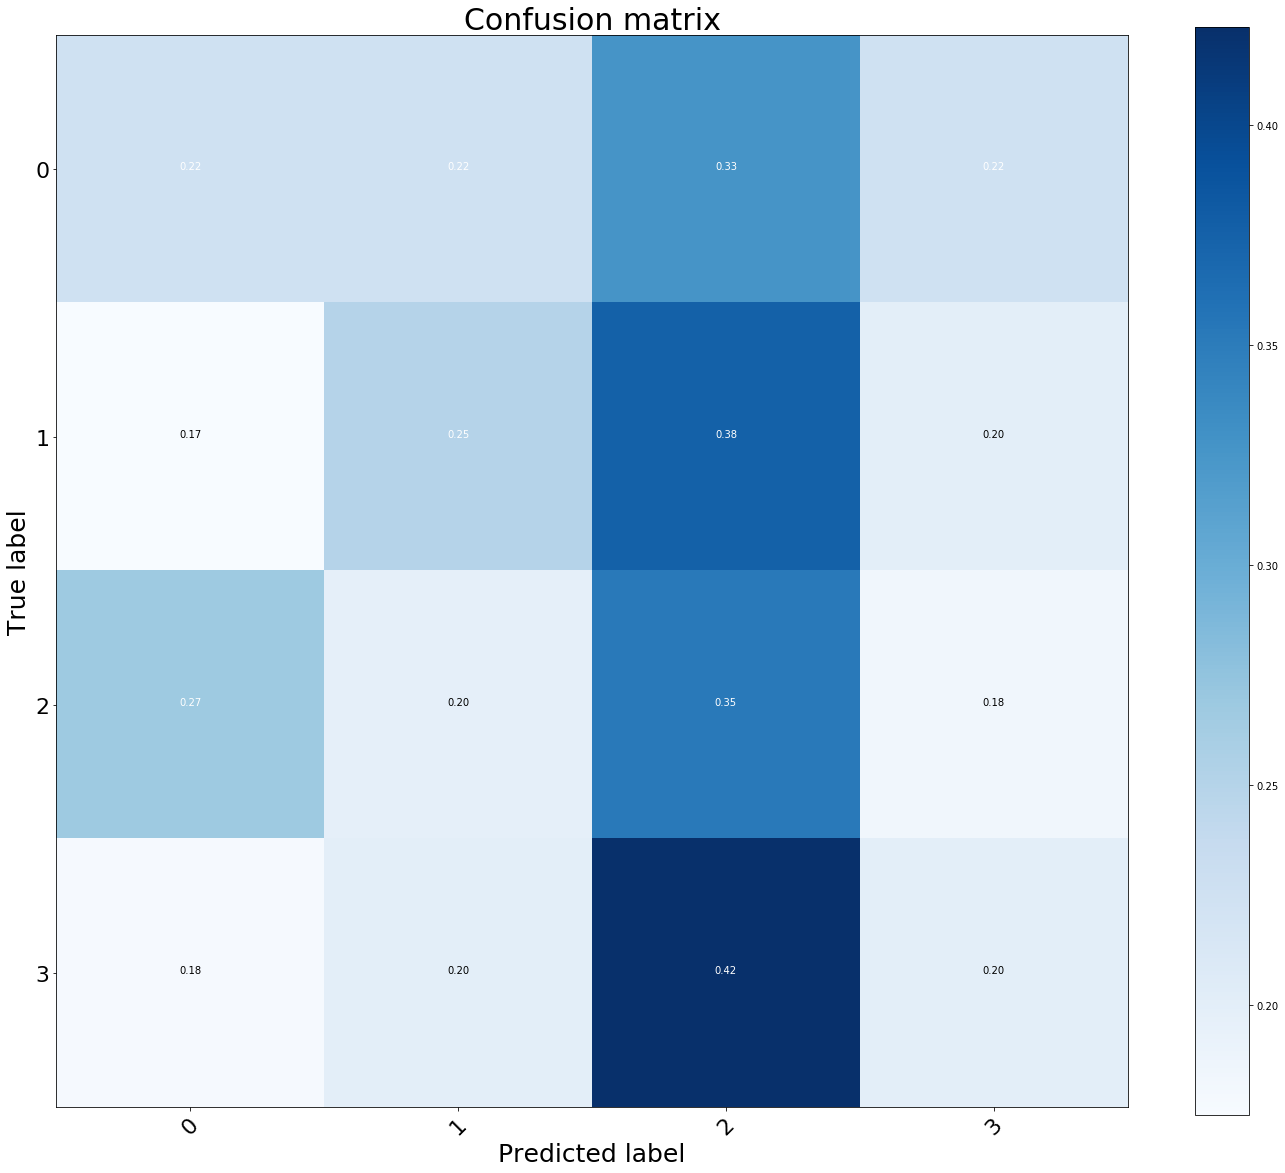

In [45]:

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
cls=[0,1,2,3]
plot_confusion_matrix(cnf_matrix, classes=cls, title="Confusion matrix")
plt.show()
